# Contents: PPO

In this notebook, you will implementa basic PPO Reinforcement learning algorithm for Lunar Lander Environment.

Write the code to define and train the agent.
Make sure to include a visualization of the end result in form of a video.

# Off-Policy and On-Policy

With **on-policy** RL, actions are generated in response to observed environment states using a certain RL policy. The outcome of these actions is collected and used to iteratively refine the parameters of the same policy. On-policy RL, therefore, uses a common behavior and target policy, which is responsible for (1) exploring the state and action spaces, and (2) optimizing the learning objective based on the data it has collected so far. Most on-policy algorithms incorporate some form of action randomness to balance between these two goals. Therefore, the RL agent may sometimes explore by selecting an action that has an uncertain outcome, while at other times it may exploit the latest policy by selecting the action that has the highest expected return for the current state. The outcome of the selected action is used to iteratively update the policy parameters, which influences subsequent behavior. E.g. SARSA


**Off-policy** RL maintains two distinct policies: A behavior policy and a target policy. While the behavior policy generates control actions for observed environment states, the target policy is trained iteratively using the subsequent outcome of the action. Off-policy RL, therefore, decouples the data collection process from policy training. A key advantage of off-policy methods is that they can learn an optimal target policy, such as a greedy reward-maximizing policy, regardless of whether the behavior policy is exploratory.

![title](https://www.ericsson.com/4aec33/assets/global/qbank/2023/12/12/reinforcement-learning-blog_on-policy-off-policy-rl-172019d41d8cd98f00b204e9800998ecf8427e.svg)
*On-policy RL iteratively refines a single behavior policy π_B that also generates control actions within the environment. Off-policy RL maintains a behavior policy π_B, and also trains a target policy, π_T, for the desired optimization objective*

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the cartpole environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![Cartpole](https://gymnasium.farama.org/_images/lunar_lander.gif)

## Creating the Environment

In [ ]:
!pip install -q swig
!pip install -q gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.5 MB/s eta 0:00:00


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create the environment
env = gym.make("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Solve here

write the code to define and train the agent:

In [ ]:
# Buffer to store trajectories
class RolloutBuffer:
  def __init__(self):
    self.actions = []
    self.states = []
    self.logprobs = []
    self.rewards = []
    self.state_values = []
    self.is_terminals = []

  def clear(self):
    del self.actions[:]
    del self.states[:]
    del self.logprobs[:]
    del self.rewards[:]
    del self.state_values[:]
    del self.is_terminals[:]

In [ ]:
class PPO(nn.Module):
    """
    PPO is an actor critic method. Here we will implement both actor and critic in one model
    """
    def __init__(self, n_observations, n_actions):
      super(PPO, self).__init__()
      self.affine1 = nn.Linear(n_observations, 128)

      # actor's layer
      self.action_head = nn.Linear(128, n_actions)

      # critic's layer
      self.value_head = nn.Linear(128, 1)

    def forward(self, x):
      """
      forward of both actor and critic
      """
      x = F.relu(self.affine1(x))

      # actor: choses action to take from state s_t
      # by returning probability of each action
      action_prob = F.softmax(self.action_head(x), dim=-1)

      # critic: evaluates being in the state s_t
      state_values = self.value_head(x)

      # return values for both actor and critic as a tuple of 2 values:
      # 1. a list with the probability of each action over the action space
      # 2. the value from state s_t
      return action_prob, state_values

    def act(self, state):
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      with torch.no_grad():
        probs, state_value = self.forward(state)
      # create a categorical distribution over the list of probabilities of actions
      m = Categorical(probs)
      # and sample an action using the distribution
      action = m.sample()
      return action, m.log_prob(action), state_value.squeeze(0)

    def evaluate(self, state, action):
      """
      Evaluate state action according to current policy
      """
      probs, state_value = self.forward(state)
      m = Categorical(probs)

      action_logprobs = m.log_prob(action)
      dist_entropy = m.entropy()

      return action_logprobs, state_value, dist_entropy

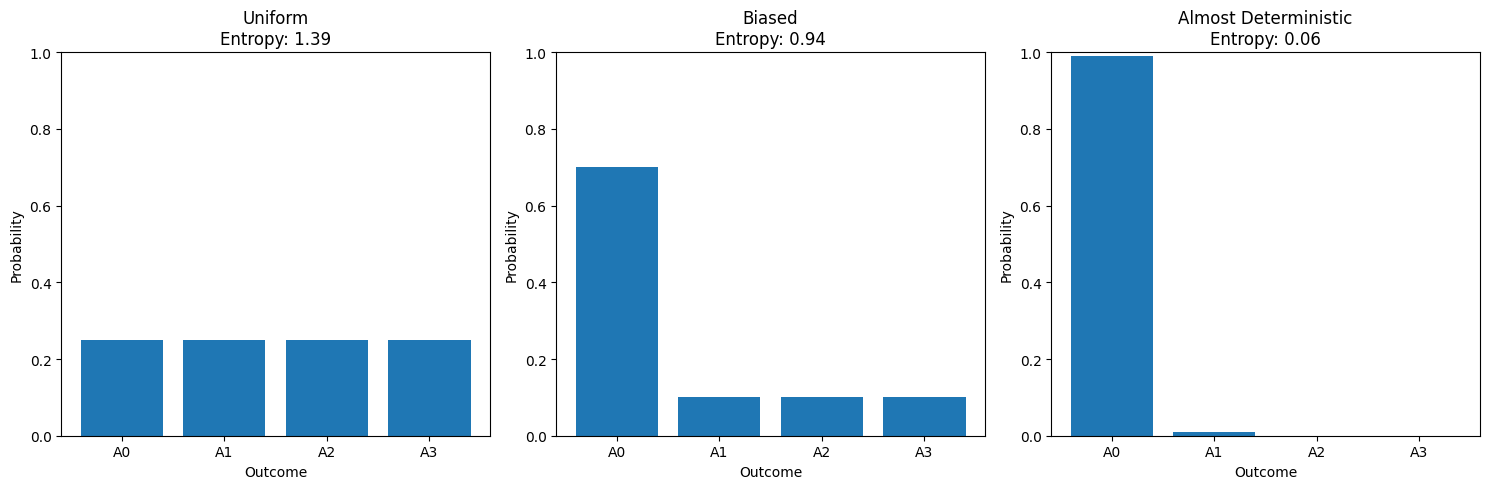

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Define the probability distributions
distributions = {
    "Uniform": [0.25, 0.25, 0.25, 0.25],
    "Biased": [0.7, 0.1, 0.1, 0.1],
    "Almost Deterministic": [0.99, 0.01, 0.00, 0.00]
}

# Calculate entropy for each distribution
entropies = {name: entropy(dist) for name, dist in distributions.items()}

# Plot the distributions and their entropies
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, dist) in zip(axes, distributions.items()):
    ax.bar(range(len(dist)), dist, tick_label=[f"A{i}" for i in range(len(dist))])
    ax.set_title(f"{name}\nEntropy: {entropies[name]:.2f}")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability")
    ax.set_xlabel("Outcome")

plt.tight_layout()
plt.show()

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 1000        # Total training episodes
max_steps = 500              # Max steps per episode
learning_rate = 1e-3         # Learning rate
gamma = 0.99                 # Discounting rate
train_freq = 5               # update policy every n timesteps
K_epochs = 10                # update policy for K epochs
eps_clip = 0.2               # clip parameter for PPO

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
action space: Discrete(4)
state size: 8
action size: 4


In [ ]:
# Intialize policy network
agent = PPO(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

In [ ]:
scores = []
buffer = RolloutBuffer()
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  state = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    action, log_prob, value = agent.act(state)
    state, reward, done, _ = env.step(action.item())

    # Saving in buffer
    buffer.states.append(torch.FloatTensor(state).to(device))
    buffer.actions.append(action)
    buffer.logprobs.append(log_prob)
    buffer.state_values.append(value)
    buffer.rewards.append(reward)
    buffer.is_terminals.append(done)

    rewards.append(reward)

    if done:
        break

  scores.append(sum(rewards))

  if episode % train_freq == 0:
    # Compute the discounted returns at each timestep
    returns = []
    discounted_reward = 0
    for reward, is_terminal in zip(reversed(buffer.rewards), reversed(buffer.is_terminals)):
      if is_terminal:
        discounted_reward = 0
      discounted_reward = reward + (gamma * discounted_reward)
      returns.insert(0, discounted_reward)

    # Normalizing the returns - actually "Standardization" (also known as Z-score normalization)
    # transforms the data to have a mean of 0 and a standard deviation of 1.

    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    returns = (returns - returns.mean()) / (returns.std() + 1e-7)

    # convert list to tensor
    old_states = torch.squeeze(torch.stack(buffer.states, dim=0)).detach().to(device)
    old_actions = torch.squeeze(torch.stack(buffer.actions, dim=0)).detach().to(device)
    old_logprobs = torch.squeeze(torch.stack(buffer.logprobs, dim=0)).detach().to(device)
    old_state_values = torch.squeeze(torch.stack(buffer.state_values, dim=0)).detach().to(device)

    # calculate advantages
    advantages = returns.detach() - old_state_values.detach()

    # Optimize policy for K epochs
    for _ in range(K_epochs):
      # Evaluating old actions and values
      logprobs, state_values, dist_entropy = agent.evaluate(old_states, old_actions)

      # match state_values tensor dimensions with returns tensor
      state_values = torch.squeeze(state_values)

      # Finding the ratio (pi_theta / pi_theta__old)
      ratios = torch.exp(logprobs - old_logprobs.detach())

      # Finding Surrogate Loss
      surr1 = ratios * advantages
      surr2 = torch.clamp(ratios, 1-eps_clip, 1+eps_clip) * advantages

      # final loss of clipped objective PPO
      loss = -torch.min(surr1, surr2) + 0.5 * F.smooth_l1_loss(state_values, returns) - 0.01 * dist_entropy

      # take gradient step
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()


    # clear buffer
    buffer.clear()


  print(f"Episode {episode}: Reward = {scores[-1]}")


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Reward = -323.5099963858082
Episode 2: Reward = -220.3735471591575
Episode 3: Reward = -130.22104005636515
Episode 4: Reward = -199.33851552500488
Episode 5: Reward = -295.14772657778803
Episode 6: Reward = -286.6982574947572
Episode 7: Reward = -118.18757043262345
Episode 8: Reward = -51.896047783780645
Episode 9: Reward = -248.30788726928049
Episode 10: Reward = -93.66026153526684
Episode 11: Reward = -122.36471510684632
Episode 12: Reward = -135.91198449991862
Episode 13: Reward = -84.89960048116257
Episode 14: Reward = -218.95169247001505
Episode 15: Reward = -87.65912198720848
Episode 16: Reward = -337.6004846689547
Episode 17: Reward = -117.03392985718375
Episode 18: Reward = -76.2185539621359
Episode 19: Reward = -121.95941824034544
Episode 20: Reward = -178.78260196337195
Episode 21: Reward = -164.53802952548773
Episode 22: Reward = -81.3406911326863
Episode 23: Reward = -294.6536236369521
Episode 24: Reward = -125.25724295630025
Episode 25: Reward = -185.96122774934

Text(0, 0.5, 'Reward')

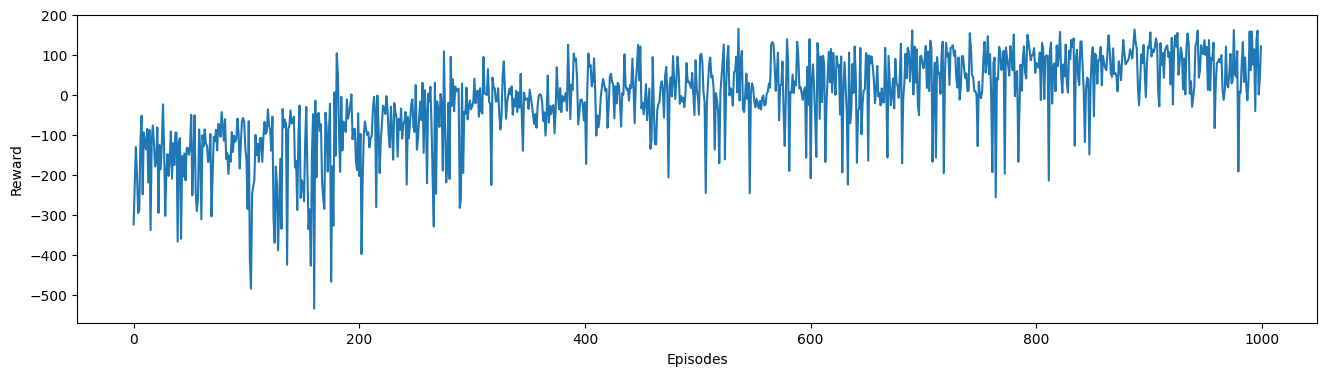

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

In [ ]:
# Intialize policy network
agent = PPO(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

scores = []
buffer = RolloutBuffer()

# Define KL divergence target and coefficient
kl_target = 0.01
beta = 0.5


for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  state = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    action, log_prob, value = agent.act(state)
    state, reward, done, _ = env.step(action.item())

    # Saving in buffer
    buffer.states.append(torch.FloatTensor(state).to(device))
    buffer.actions.append(action)
    buffer.logprobs.append(log_prob)
    buffer.state_values.append(value)
    buffer.rewards.append(reward)
    buffer.is_terminals.append(done)

    rewards.append(reward)

    if done:
        break

  scores.append(sum(rewards))

  if episode % train_freq == 0:
    # Compute the discounted returns at each timestep
    returns = []
    discounted_reward = 0
    for reward, is_terminal in zip(reversed(buffer.rewards), reversed(buffer.is_terminals)):
      if is_terminal:
        discounted_reward = 0
      discounted_reward = reward + (gamma * discounted_reward)
      returns.insert(0, discounted_reward)

    # Normalizing the returns - actually "Standardization" (also known as Z-score normalization)
    # transforms the data to have a mean of 0 and a standard deviation of 1.

    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    returns = (returns - returns.mean()) / (returns.std() + 1e-7)

    # convert list to tensor
    old_states = torch.squeeze(torch.stack(buffer.states, dim=0)).detach().to(device)
    old_actions = torch.squeeze(torch.stack(buffer.actions, dim=0)).detach().to(device)
    old_logprobs = torch.squeeze(torch.stack(buffer.logprobs, dim=0)).detach().to(device)
    old_state_values = torch.squeeze(torch.stack(buffer.state_values, dim=0)).detach().to(device)

    # calculate advantages
    advantages = returns.detach() - old_state_values.detach()

    # Optimize policy for K epochs
    for _ in range(K_epochs):
      # Evaluating old actions and values
      logprobs, state_values, dist_entropy = agent.evaluate(old_states, old_actions)

      # match state_values tensor dimensions with returns tensor
      state_values = torch.squeeze(state_values)

      # Finding the ratio (pi_theta / pi_theta__old)
      ratios = torch.exp(logprobs - old_logprobs.detach())

      # Finding Surrogate Loss
      surr = ratios * advantages

      # Calculate KL divergence
      kl_divergence = torch.mean(old_logprobs - logprobs)

      # Final loss with KL penalty
      loss = -surr + beta * kl_divergence + 0.5 * F.smooth_l1_loss(state_values, returns) - 0.01 * dist_entropy

      # Update beta to control the KL divergence
      if kl_divergence > 1.5 * kl_target:
          beta *= 1.5
      elif kl_divergence < kl_target / 1.5:
          beta /= 1.5

      # take gradient step
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()


    # clear buffer
    buffer.clear()


  print(f"Episode {episode}: Reward = {scores[-1]}")


Episode 1: Reward = -444.8551766128788
Episode 2: Reward = -249.8685937261835
Episode 3: Reward = -224.91969918802909
Episode 4: Reward = -49.36599360510921
Episode 5: Reward = -77.45419890236273
Episode 6: Reward = -62.15363090478978
Episode 7: Reward = -282.40305623185264
Episode 8: Reward = -142.49265881554558
Episode 9: Reward = -307.7682285838401
Episode 10: Reward = 0.35483388521268466
Episode 11: Reward = -256.0534295120202
Episode 12: Reward = -280.84884458960494
Episode 13: Reward = -123.31437135924341
Episode 14: Reward = -370.706585766442
Episode 15: Reward = -102.07900275026842
Episode 16: Reward = -84.46837023042437
Episode 17: Reward = -83.53946111995316
Episode 18: Reward = -324.0971872316503
Episode 19: Reward = -124.29503760451101
Episode 20: Reward = -78.31325789470387
Episode 21: Reward = -179.41229563059727
Episode 22: Reward = -134.6891414465578
Episode 23: Reward = -117.03194206705487
Episode 24: Reward = -139.38767497733556
Episode 25: Reward = -94.03777217954045

Text(0, 0.5, 'Reward')

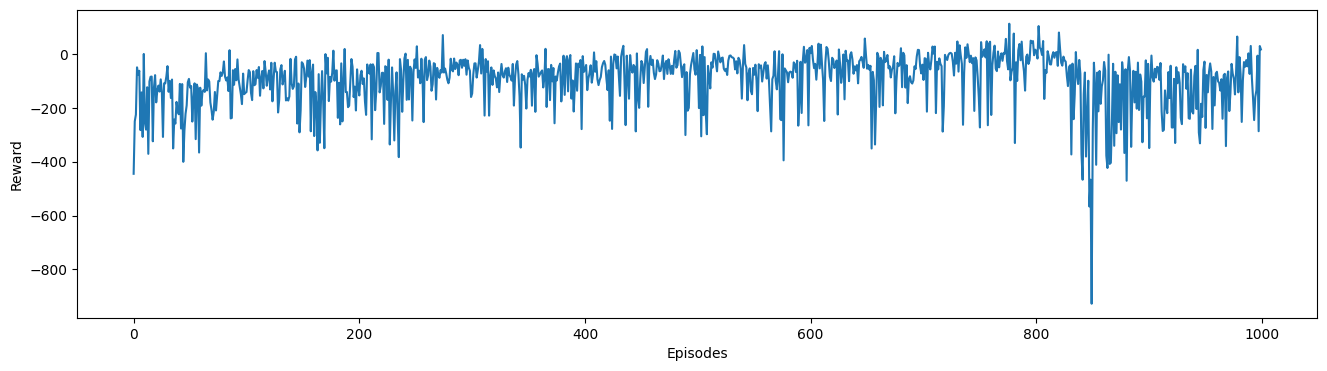

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

You are provided with some functions which will help you visualize the results as a video.
Feel free to wrie your own code for visualization if you prefer

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name, max_steps=500):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()

        # Write your code to choose an action here.
        action, _, _ = agent.act(state)



        next_state, reward, done, info = env.step(action.item())
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [ ]:
show_video_of_model("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead

In [ ]:
show_video("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
